In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from typing import List
plt.style.use('default')

## Bài 1: Tính số pi thông qua Monte Carlo

In [ ]:
def calculate_ball(n_balls):
  """
  - chọn M là một phần tư hình tròn với bán kính 1.
  - tạo một hình vuông có bán kính bằng 1 bao bên ngoài.
  - d_M = 1/4 * pi * radius^2 = 1/4 * pi => pi = 4 * d_M
  - number_ball_inside / number_ball_total -> d_M / d_square = d_M khi mà số
  - lượng bóng đủ lớn, khi đó ball_inside * 4 gần giống số pi
  """
  ball_inside = []
  ball_outside = []

  for i in range(n_balls):
    x = np.random.uniform(0,1)
    y = np.random.uniform(0,1)
    if math.sqrt(x**2 + y**2) < 1:
      ball_inside.append((x,y))
    else:
      ball_outside.append((x,y))

  return ball_inside, ball_outside

In [ ]:
def calculate_pi(n_balls):
  inside, _ = calculate_ball(n_balls)
  return 4 * len(inside)

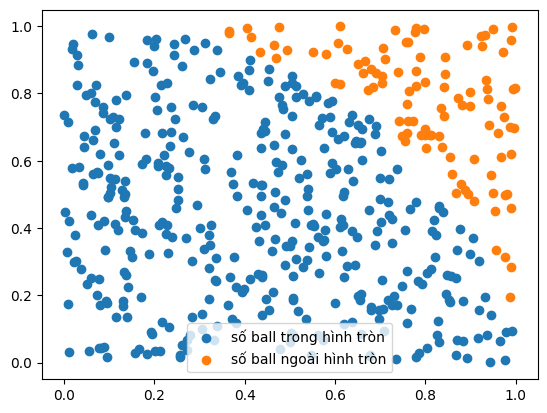

In [ ]:
inside, outside = calculate_ball(500)
inside_list = list(zip(*inside))
outside_list = list(zip(*outside))

plt.scatter(inside_list[0], inside_list[1], label="số ball trong hình tròn")
plt.scatter(outside_list[0], outside_list[1], label="số ball ngoài hình tròn")
plt.legend()

## Bài 2: Dùng Genetic Algorithm tính phương trình $ax^2 + bx + c = 0$ với $a,b,c$ do người dùng nhập vào.

In [ ]:
def bin_to_dec(bin) -> int:
  """
  chuyển một array nhị phân (gồm 0,1) dạng bù 2 sang giá trị thập phân
  """
  res = 0
  for i in range(len(bin)-1, -1, -1):
    val = 2**i
    if i == len(bin)-1:
      val = -val
    res = res + bin[i]*val
  return res

def f(a, b, c, x) -> float:
  """
  tính giá trị f(x) = ax^2 + bx + c
  """
  return a*(x**2) + b*x + c

In [ ]:
class QuadraticGenetic:
  def __init__(self,
               a: float, b: float, c: float,
               iter: int,
               bits: int) -> None:
    self.a = a
    self.b = b
    self.c = c

    # số lần lặp (hoặc số lượng thế hệ)
    self.n_iter = iter

    # số lượng bits của mỗi cá thể
    self.n_bits = bits

    # số lượng cá thể của một quần thể (từ 2->9)
    self.amount = np.random.randint(2, 10)

    # tỉ lệ lai ghép
    self.cross_rate = np.random.rand()

    # tỉ lệ đột biến
    self.mut_rate = np.random.rand()

    # quần thể
    self.pol = []

    # thế hệ quần thể
    self.time = -1

  def __fitness_score(self, sol) -> float:
    """
    tính hệ số fitness của cá thể sol
    """
    return abs(1000 - f(self.a, self.b, self.c, bin_to_dec(sol)))

  def __crossover(self, parent1, parent2) -> List[List[int]]:
    """
    Lai ghép parent1 và parent2 tạo ra child1 và child2.
    Mặc định sẽ là copy.
    Nếu không thì sẽ hoán đổi bit của parent1 với parent2.
    """
    child1, child2 = parent1.copy(), parent2.copy()

    if np.random.rand() < self.cross_rate:
      # chọn random 1 điểm trên string và chia nó ra
      split_point = np.random.randint(1, len(parent1))

      child1 = parent1[:split_point] + parent2[split_point:]
      child2 = parent2[:split_point] + parent2[split_point:]

    return [child1, child2]

  def __mutation(self, candidate) -> List[int]:
    """
    Dùng để "đột biến" cá thể bằng cách lật bit
    """
    for i in range(len(candidate)):
      if np.random.rand() < self.mut_rate:
        candidate[i] = 1 - candidate[i]

  def __str__(self):
    return f"Các nghiệm là {[bin_to_dec(c) for c in self.pol]}"

  def __individual_prob(self) -> List[int]:
    """
    trả về xác suất được chọn của mỗi cá thể theo công thức:
    p_i = fitness(i) / sum_{j = 1}^n_pol fitness(j)
    """
    scored = [self.__fitness_score(c) for c in self.pol]
    sum_fitness = sum(scored)
    return [(scored[i] / sum_fitness) for i in range(0, len(scored))]

  def select_population(self, n_indi) -> List[int]:
    """
    chọn ra những cá thể tốt nhất
    dùng Roulette Wheel Selection
    (ref: https://en.wikipedia.org/wiki/Fitness_proportionate_selection)
    n_indi là số lượng cá thể ta muốn chọn
    """
    return random.choices(population=self.pol,
                          weights=self.__individual_prob(),
                          k=n_indi)

  def generate_population(self) -> None:
    """
    sinh ra thế hệ mới
    nếu không phải thế hệ đầu tiên thì sẽ thực hiện "lai ghép" và "đột biến"
    """
    if self.time == -1: # thế hệ đầu tiên
      self.pol = [np.random.randint(2, size=(self.n_bits)).tolist()
                  for _ in range(0, self.amount)]

    else: # thực hiện lai tạo
      n_indi = 2 # bỏ qua bước chọn nếu số lượng là 2
      selected = self.pol
      if self.amount > 2:
        # random số chẵn trong khoảng từ amount/2 cho đến amount
        n_indi = random.randrange(math.ceil(self.amount/2), self.amount, 2)
        # tiến hành chọn
        selected = self.select_population(n_indi)
      # tiến hành lai ghép
      child = []
      for i in range(0, n_indi, 2):
        if i + 1 < n_indi:
          p1, p2 = selected[i], selected[i+1]
          for c in self.__crossover(p1, p2):
            self.__mutation(c)
            child.append(c)
      self.pol = self.pol + child
      # nếu lớn hơn amount thì tiếp tục chọn
      if len(self.pol) > self.amount:
        self.pol = self.select_population(self.amount)

    # tăng thế hệ lên 1
    self.time += 1

    # mỗi thế hệ có cross_rate và mut_rate khác nhau
    self.cross_rate = np.random.rand()
    self.mut_rate = np.random.rand()

  def evaluate(self):
    """
    dùng để đánh giá thế hệ
    trả về 1 cá thể nếu có cá thể "đủ gần" với nghiệm chính
    trả về cả quần thể nếu chưa thoả mãn
    trả về cá thể có fitness tốt nhất (nhỏ nhất) trong quần thể nếu hết lần lặp
    """
    scored = [self.__fitness_score(c) for c in self.pol]

    for i in range(0, self.amount):
      if scored[i] < 5: # đủ gần với nghiệm
        return bin_to_dec(self.pol[i])

    if self.time == self.n_iter: # hết lần lặp
      min_idx = scored.index(min(scored))
      return bin_to_dec(self.pol[min_idx])

    return self.pol

In [ ]:
def solve_quadratic_genetic(a, b, c, iter, bits = 8):
  g = QuadraticGenetic(a, b, c, iter, bits)

  # thế hệ đầu tiên
  g.generate_population()
  print("Thế hệ đầu tiên:")
  print(g)

  # đánh giá thế hệ
  result = g.evaluate()
  if type(result) is not list: # nếu chỉ gồm 1 phần tử
    return result

  while True:
    g.generate_population() # sinh thế hệ mới
    print(f"Thế hệ thứ {g.time}:")
    print(g)
    result = g.evaluate() # đánh giá thế hệ đó
    if type(result) is not list:
      return result

In [ ]:
print(f"Nghiệm tốt nhất là: {solve_quadratic_genetic(2, -3, 5, 50, 4)}")

Thế hệ đầu tiên:
Các nghiệm là [-6, 6, 0, 1, -1]
Thế hệ thứ 1:
Các nghiệm là [-1, 0, 6, -1, -6]
Thế hệ thứ 2:
Các nghiệm là [0, -1, -1, -1, 6]
Thế hệ thứ 3:
Các nghiệm là [-1, -1, -1, 0, 3]
Thế hệ thứ 4:
Các nghiệm là [-1, -1, -1, -1, -1]
Thế hệ thứ 5:
Các nghiệm là [-1, -1, 3, -3, -1]
Thế hệ thứ 6:
Các nghiệm là [-1, -1, -1, -3, -3]
Thế hệ thứ 7:
Các nghiệm là [5, -1, -1, -1, -3]
Thế hệ thứ 8:
Các nghiệm là [4, -1, -1, -1, 4]
Thế hệ thứ 9:
Các nghiệm là [-1, -1, -1, -2, 4]
Thế hệ thứ 10:
Các nghiệm là [-2, -6, -1, -1, 7]
Thế hệ thứ 11:
Các nghiệm là [-3, -2, -5, -3, -1]
Thế hệ thứ 12:
Các nghiệm là [-2, -1, -3, -3, -5]
Thế hệ thứ 13:
Các nghiệm là [-2, -1, -2, -2, -5]
Thế hệ thứ 14:
Các nghiệm là [-5, -3, -5, -2, -2]
Thế hệ thứ 15:
Các nghiệm là [-2, -2, -2, -2, -2]
Thế hệ thứ 16:
Các nghiệm là [-2, -2, -2, -2, -2]
Thế hệ thứ 17:
Các nghiệm là [-2, -2, -2, -4, -2]
Thế hệ thứ 18:
Các nghiệm là [-1, -1, -2, -2, -2]
Thế hệ thứ 19:
Các nghiệm là [-2, -1, -1, -1, -4]
Thế hệ thứ 20:
Các ngh